In [1]:
from exp.expdata import LotkaVolterraExp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
import jax.numpy as jnp
import jax
jax.config.update('jax_enable_x64',True)

/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In [2]:
noise = 0.2
dt_train = 5.5 # from est_period / 2 + epsish

t1=100.
expdata = LotkaVolterraExp(t0=0.,t1=t1,noise=noise, dt_train=dt_train,n_colloc=500, feature_names=['x','y'],seed=1234)

In [3]:
extra_t_train= jnp.linspace(0,1,5)[1:]
expdata.t_train = jnp.hstack([expdata.t_train,extra_t_train])
t_as = jnp.argsort(expdata.t_train)
expdata.t_train = expdata.t_train[t_as]
expdata.x_train = jnp.vstack(
    [
        expdata.x_train,
        jax.vmap(expdata.system_sol.evaluate)(extra_t_train)
    ]
)[t_as]

x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train
t_train.shape

(23,)

In [4]:
def state(t):
    return np.array(expdata.system_sol.evaluate(t))

def loss(p):
    return np.linalg.norm(np.array(expdata.initial_state) - state(p))**2

from scipy.optimize import minimize_scalar
period_sol = minimize_scalar(loss,bounds = (5,15.))
period_est = period_sol.x
period_est /2

np.float64(5.394439184459843)

In [5]:

# plt.plot(x_true[:,0], x_true[:,1])
# plt.xlabel(r"$x$")
# plt.ylabel(r"$y$")
# plt.show()

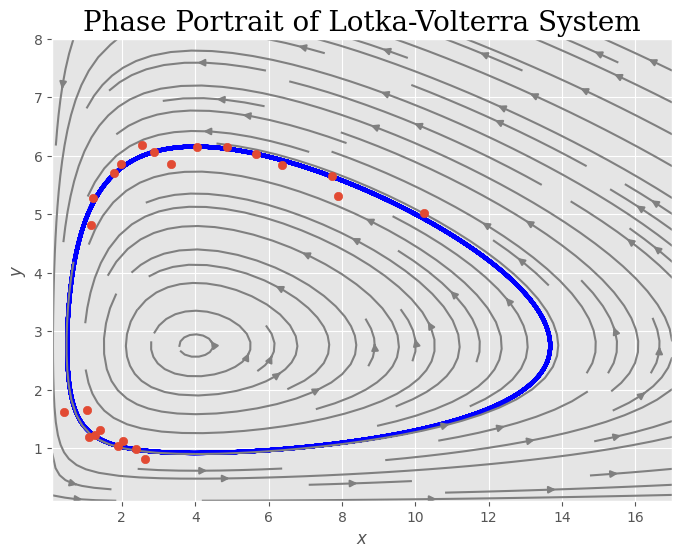

In [7]:
def lotka_volterra(t, z, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Create a grid of initial conditions
x_vals = np.linspace(0.1, 17, 501)
y_vals = np.linspace(0.1, 8, 501)

X0, Y0 = np.meshgrid(x_vals, y_vals)
U = np.zeros(X0.shape)
V = np.zeros(Y0.shape)

# Evaluate the vector field
for i in range(X0.shape[0]):
    for j in range(X0.shape[1]):
        dxdt, dydt = lotka_volterra(0, [X0[i, j], Y0[i, j]])
        U[i, j] = dxdt
        V[i, j] = dydt

# Normalize the arrows
speed = np.sqrt(U**2 + V**2)
U /= speed
V /= speed

# Plot phase portrait
plt.figure(figsize=(8, 6))
plt.streamplot(x_vals, y_vals, U, V, color='gray')
plt.xlabel(r'$x$',family='serif')
plt.ylabel(r'$y$',family='serif')
plt.title('Phase Portrait of Lotka-Volterra System',family='serif',size=20)

# Overlay a few solution trajectories
initial_conditions = [[10, 5], [2, 1], [1, 2], [3, 3], [4, 1]]

for z0 in initial_conditions[:1]:
    sol = solve_ivp(lotka_volterra, [0, 25], z0, dense_output=True)
    t = np.linspace(0, 20, 1001)
    z = sol.sol(t)
    z = x_true.T
    plt.plot(z[0], z[1], label=rf'$x_0=${z0[0]}, $y_0$={z0[1]}',lw=3,c='blue',zorder=1)

cutoff2 = 1200
cutoff2 = -70
# plt.plot(x_pred[:cutoff2,0], x_pred[:cutoff2,1],linestyle='--',alpha=0.7)
# plt.legend(prop={'family':'serif'})
plt.scatter(x_train[:,0], x_train[:,1],zorder=2)
plt.grid(True)
plt.savefig("figures_lv/lv_phase_portrait_single.pdf")
plt.show()

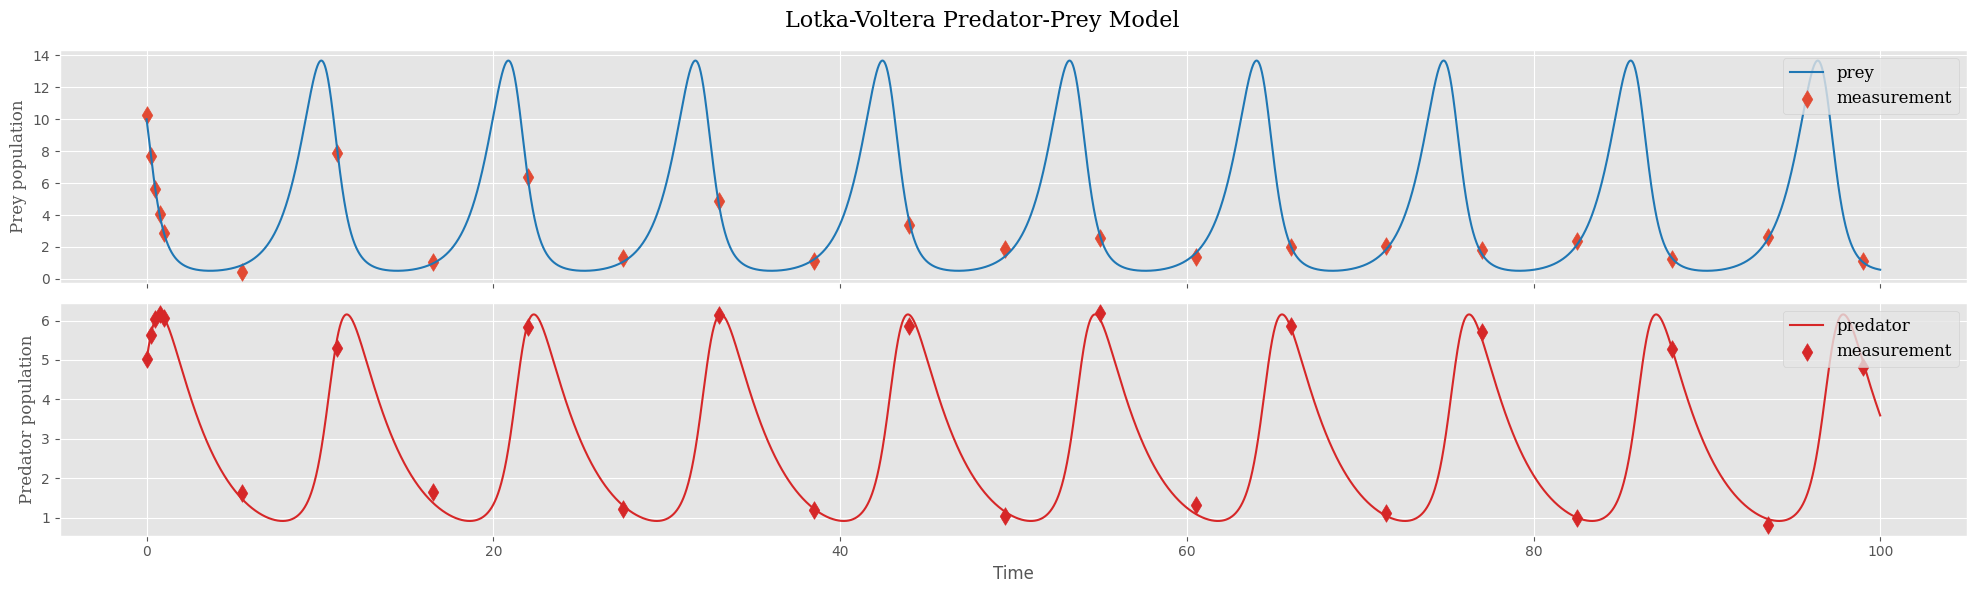

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="prey", c='tab:blue',)
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80)
ax1.set_ylabel("Prey population", fontname=fontname)
ax1.legend(loc='upper right',prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='tab:red', marker='d',s=80)
ax2.set_ylabel("Predator population", fontname=fontname)
ax2.set_xlabel("Time")
ax2.grid(True)
ax2.legend(loc='upper right',prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

# Jsindy model learning

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

In [10]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
kernel=None

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 10.*500
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [11]:
from exp.evaluate.jsindy import evaluate_jmodel

In [12]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
print()
expdata.print()
metrics['xdot_metrics']

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.00109617, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 5000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 3.716e+03, gradnorm = 4.454e+03, alpha = 5.0, improvement_ratio = 0.3662
Iteration 1, loss = 3.48e+03, gradnorm = 3.219e+04, alpha = 9.0, improvement_ratio = 0.06646
Iteration 2, loss = 377.8, gradnorm = 7.886e+04, alpha = 7.5, improvement_ratio = 0.9088
Iteration 3, loss = 117.7, gradnorm = 2.747e+04, alpha = 7.5, improvement_ratio = 0.7418
Iteration 4, loss = 29.93, gradnorm = 2.314e+04, alpha = 6.25, improvement_ratio = 0.9174
Iteration 5, loss = 16.44, gradnorm = 8.51e+03, alpha = 5.208, improvement_ratio = 0.9025
Line Search Failed!
Final Iteration Results
Iteration 140, loss = 1.791, gradnorm = 0.0002783, alpha = 12.18, improvement_ratio = -7.202e+03
Model after smooth warm start
(x)' = 0.755 1 + 1.155 x + -0.360 y + -0.009 x^2 + -0.400 x y + 0.033 y^2
(y)' = -0.986 1 + 0.203 x + 0.219 y + -0.017 x^2 + 0.087 x y + -0.079 y^2
Alternating Activeset Sparsifier
Line search Failed
3 active coeffs changed
Line search Failed
Active set stabilized
Line search Failed
(

{'mse': Array(0.07916605, dtype=float64),
 'rmse': np.float64(0.28136461565455206),
 'mae': np.float64(0.22050121628147748),
 'max_abs_error': np.float64(0.6856831446558234),
 'normalized_mse': Array(0.01106947, dtype=float64),
 'relative_l2_error': np.float64(0.10518985269106455)}

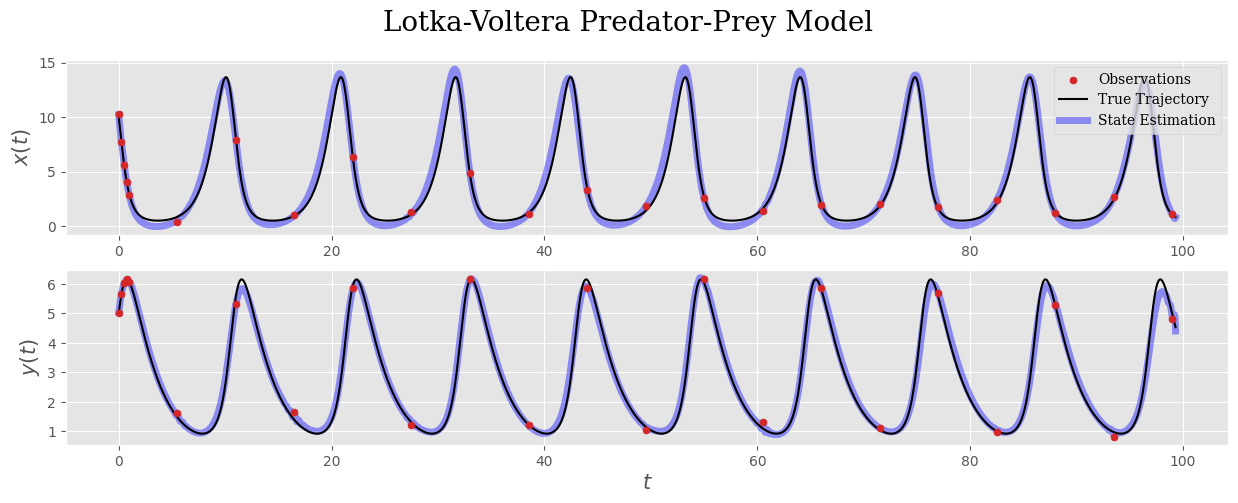

In [14]:
x_pred = model.predict_state(expdata.t_true)
x_true = expdata.x_true

cutoff = -70
family='serif'
fig, ax = plt.subplots(2,1, figsize=(15,5))
ylabels = [r"$x(t)$", r"$y(t)$"]
for idx in range(2):
    ax[idx].scatter(t_train, x_train[:,idx],c='tab:red', label='Observations',s=25,zorder=3)
    ax[idx].plot(t_true[:cutoff], x_true[:cutoff,idx], label='True Trajectory',c='black',zorder=2)
    ax[idx].plot(t_true[:cutoff], x_pred[:cutoff,idx], label='State Estimation', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)
    ax[idx].grid(True)
    ax[idx].set_ylabel(ylabels[idx], size=15, family=family)
    if idx==0:
        ax[idx].legend(prop={'family':family})
    if idx == 1:
        ax[idx].set_xlabel(r"$t$",size=15, family=family)
plt.suptitle("Lotka-Voltera Predator-Prey Model", family=family,size=20)
plt.savefig(f"figures_lv/lv_noise_{noise}_dt_{dt_train}_t1_{t1}.pdf")
plt.show()

## Plot with extended unseen domain

In [18]:
import diffrax
from data.lotkavolterra import lotka_volterra_system



true_lv_system = jax.jit(lotka_volterra_system)

jit_lv_pred = jax.jit(model.predict)


def learn_lv_system(t,x,args):
    return jit_lv_pred(x)



def simulate_sol(y0,system, t0=expdata.t0,t1=expdata.t1,dt=expdata.dt,t_eval = expdata.t_true, args = None):
    term = diffrax.ODETerm(system)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt)
    )

    return jax.vmap(sol.evaluate)(t_eval)


In [20]:
lv_args = (1.1,0.4,0.4,0.1)

x_true_extend = simulate_sol(x_train[-1],system=true_lv_system,args=lv_args)
x_sim_extend = simulate_sol(x_train[-1],system=learn_lv_system)

In [25]:
t_true[cutoff], t_true[:cutoff][-1]

(Array(99.3, dtype=float64), Array(99.29, dtype=float64))

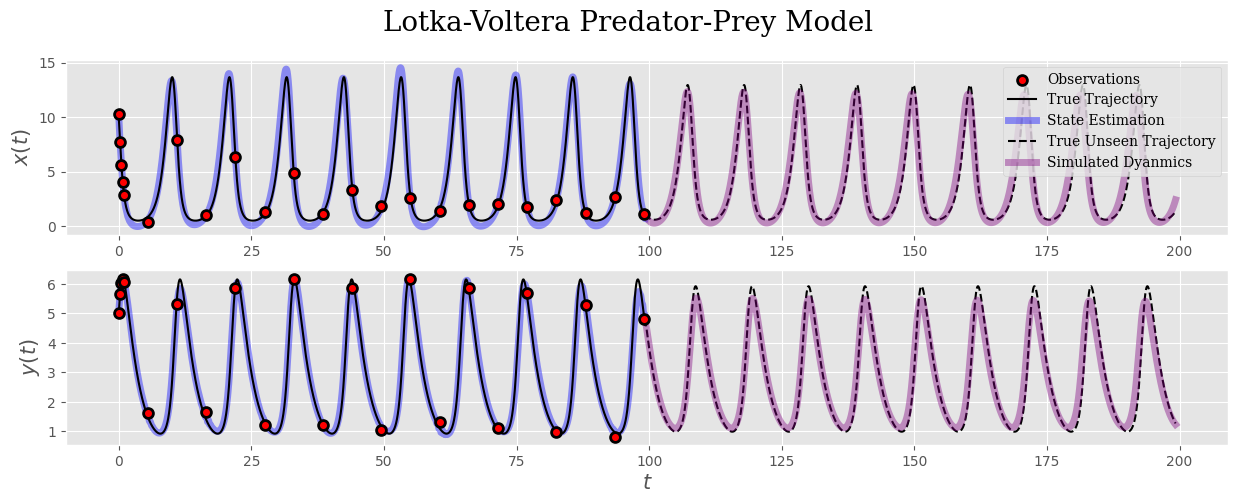

In [46]:
cutoff = -75
family='serif'
fig, ax = plt.subplots(2,1, figsize=(15,5))
ylabels = [r"$x(t)$", r"$y(t)$"]
for idx in range(2):
    ax[idx].scatter(t_train, x_train[:,idx],facecolors='red',edgecolors='black',lw=2, label='Observations',s=50,zorder=3)
    
    ax[idx].plot(t_true[:cutoff], x_true[:cutoff,idx], label='True Trajectory',c='black',zorder=2)
    ax[idx].plot(t_true[:cutoff], x_pred[:cutoff,idx], label='State Estimation', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)

    # extension 
    t_extend = t_true + t_true[cutoff]
    ax[idx].plot(t_extend,x_true_extend[:,idx], c='black', linestyle='--', label='True Unseen Trajectory')    

    ax[idx].plot(t_extend,x_sim_extend[:,idx],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dyanmics')

    ax[idx].grid(True)
    ax[idx].set_ylabel(ylabels[idx], size=15, family=family)
    if idx==0:
        ax[idx].legend(prop={'family':family})
    if idx == 1:
        ax[idx].set_xlabel(r"$t$",size=15, family=family)
plt.suptitle("Lotka-Voltera Predator-Prey Model", family=family,size=20)
plt.savefig(f"figures_lv/lv_noise_{noise}_dt_{dt_train}_t1_{t1}_unseen_traj.pdf")
plt.show()

## $\dot{x}$

In [47]:
xdot_pred = model.predict(x_true)
xdot_true = expdata.x_dot

In [48]:
l2_err_jsindy = np.linalg.norm(xdot_pred - xdot_true) / np.linalg.norm(xdot_true)
l2_err_jsindy

np.float64(0.10518985269106455)

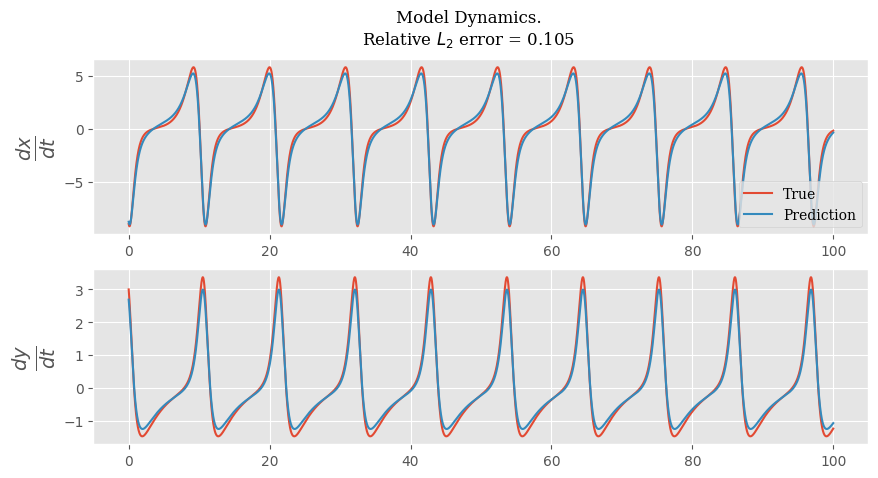

In [49]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,5))
ax1.plot(t_true, xdot_true[:,0], label="True")
ax1.plot(t_true, xdot_pred[:,0],label="Prediction")
ax1.set_ylabel(r"$\frac{dx}{dt}$",size=20)
ax1.legend(prop={'family':'serif'})
ax2.plot(t_true, xdot_true[:,1])
ax2.plot(t_true, xdot_pred[:,1])
ax2.set_ylabel(r"$\frac{dy}{dt}$",size=20)

plt.suptitle("Model Dynamics.\n"+f"Relative $L_2$ error = {l2_err_jsindy:.3f}", family='serif')
plt.show()

## Phase portrait figure

In [50]:
from tqdm.auto import tqdm 
from data.lotkavolterra import lotka_volterra_system

# def lotka_volterra(t, z, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
#     x, y = z
#     dxdt = alpha * x - beta * x * y
#     dydt = delta * x * y - gamma * y
#     return [dxdt, dydt]

# Create a grid of initial conditions
n_points = 201
x_vals = np.linspace(0.1, 18.1, n_points)
y_vals = np.linspace(0.1, 8, n_points)

X0, Y0 = np.meshgrid(x_vals, y_vals)
U = np.zeros(X0.shape)
V = np.zeros(Y0.shape)
Uj = np.zeros(X0.shape)
Vj = np.zeros(Y0.shape)
jitpred = jax.jit(model.predict)

# Evaluate the vector field
for i in tqdm(range(X0.shape[0])):
    for j in range(X0.shape[1]):
        arr = [X0[i, j], Y0[i, j]]
        dxdt, dydt = lotka_volterra_system(0, arr,args=(1.1,0.4,0.4,0.1))
        U[i, j] = dxdt
        V[i, j] = dydt

        dxdt, dydt = jitpred(jnp.array(arr))
        Uj[i, j] = dxdt
        Vj[i, j] = dydt

        

# Normalize the arrows
speed = np.sqrt(U**2 + V**2)
U /= speed
V /= speed


speed = np.sqrt(Uj**2 + Vj**2)
Uj /= speed
Vj /= speed


  0%|          | 0/201 [00:00<?, ?it/s]

## simulate trajectory with learned dynamics

In [51]:
initial_conditions = [
    jnp.array([10.,5.]),
    jnp.array(([4.,2.])),
    jnp.array([2.,7.]),
    jnp.array([4.,8.]),
    jnp.array([4.,5.])
]

true_traj = []
sim_traj = []
for y0 in tqdm(initial_conditions):
    true_traj.append(simulate_sol(y0,lotka_volterra_system,args=expdata.lv_args))
    sim_traj.append(simulate_sol(y0,learn_lv_system))

  0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
float(initial_conditions[0][0])

10.0

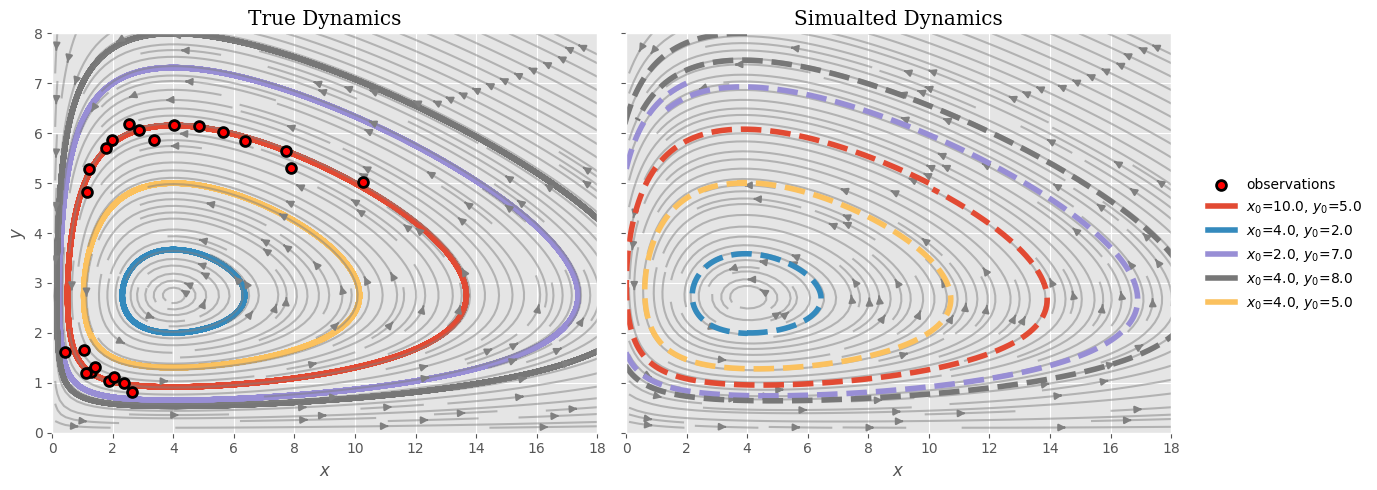

In [53]:
import matplotlib.lines as mlines

fig, axs = plt.subplots(1, 2, figsize=(12, 5),sharey=True)
axs = axs.flatten()

sp0 = axs[0].streamplot(x_vals, y_vals, U, V, density=2, color='gray')
axs[0].scatter(x_train[:, 0], x_train[:, 1], zorder=2,facecolors='red',edgecolors='black',marker='.',s=200,lw=2,label="observations")
axs[0].set_ylabel(r"$y$")
axs[0].set_xlabel(r"$x$")
axs[0].set_title("True Dynamics",family='serif')

# Change alpha for both lines and arrows
sp0.lines.set_alpha(0.5)
sp0.arrows.set_alpha(0.5)

cutoff=-1
cutoffs = [1080, 1000,1150,1250,1050]
sp1 = axs[1].streamplot(x_vals, y_vals, Uj, Vj, density=2, color='gray')


# Plot trajectories 
for idx, (x_true,x_pred) in enumerate(zip(true_traj,sim_traj)):

    cutoff = cutoffs[idx]

    c=None
    ic = initial_conditions[idx]
    label = rf"$x_0$={float(ic[0])}, $y_0$={float(ic[1])}"
    axs[0].plot(x_true[:,0],x_true[:,1],
                lw=4,zorder=1,c=c,label=label)

    axs[1].plot(x_pred[:cutoff,0],x_pred[:cutoff,1],
                linestyle='--',lw=4,c=c)

axs[1].set_xlabel(r"$x$")
axs[1].set_title("Simualted Dynamics", family='serif')

axs[0].set_xlim(0,18)
axs[1].set_xlim(0,18)

axs[0].set_ylim(0,8)
axs[1].set_ylim(0,8)


# Change alpha for both lines and arrows
sp1.lines.set_alpha(0.5)
sp1.arrows.set_alpha(0.5)


fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

plt.tight_layout()

fig.savefig("figures_lv/lv_phase_portrait.pdf",bbox_inches='tight')
plt.show()


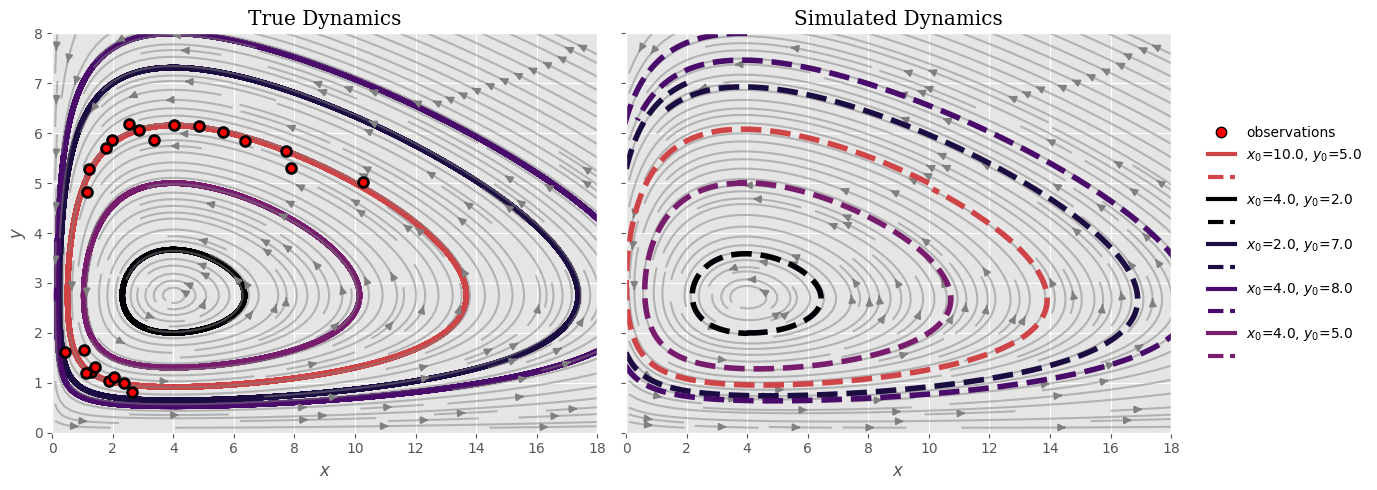

In [63]:
import matplotlib.lines as mlines

cmap = plt.cm.inferno
colors = cmap(0,1,len(initial_conditions)+1)

colors = plt.cm.tab10.colors

colors = [
    "#000004",
    "#1b0c41",
    "#4a0c6b",
    "#781c6d",
    "#a52c60",
    "#cf4446",
    "#ed6925",
    "#fb9b06",
    "#f7d13d",
    "#fcffa4"
]

colors = [
    "#cf4446",
    "#000004",
    "#1b0c41",
    "#4a0c6b",
    "#781c6d",
    "#a52c60",
    "#ed6925",
    "#fb9b06",
    "#f7d13d",
    "#fcffa4"
]

def inferno_colors(n):
    cmap = plt.cm.inferno
    values = np.linspace(0, 1, n)
    colors = [cmap(v) for v in values]  # RGBA tuples
    # Convert RGBA to hex
    hex_colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for r, g, b, _ in colors]
    return hex_colors

# Example usage:
# n = 6
# colors = inferno_colors(n)


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs = axs.flatten()

# --- First subplot: True dynamics ---
sp0 = axs[0].streamplot(x_vals, y_vals, U, V, density=2, color='gray')
axs[0].scatter(x_train[:, 0], x_train[:, 1],
               zorder=2, facecolors='red', edgecolors='black',
               marker='.', s=200, lw=2, label="observations")
axs[0].set_ylabel(r"$y$")
axs[0].set_xlabel(r"$x$")
axs[0].set_title("True Dynamics", family='serif')
sp0.lines.set_alpha(0.5)
sp0.arrows.set_alpha(0.5)

# --- Second subplot: Simulated dynamics ---
cutoffs = [1080, 1000, 1150, 1250, 1050]
sp1 = axs[1].streamplot(x_vals, y_vals, Uj, Vj, density=2, color='gray')

legend_handles = [
    mlines.Line2D([], [], marker='.', color='black', markerfacecolor='red',
                  markeredgecolor='black', markersize=15, lw=0, label="observations")
]

# Plot trajectories and store handles
for idx, (x_true, x_pred) in enumerate(zip(true_traj, sim_traj)):
    cutoff = cutoffs[idx]
    c = colors[idx]  # You can assign your own colors here
    # c=None
    ic = initial_conditions[idx]
    label = rf"$x_0$={float(ic[0])}, $y_0$={float(ic[1])}"

    # Solid line: true
    axs[0].plot(x_true[:, 0], x_true[:, 1], lw=4, zorder=1, c=c)
    solid_line = mlines.Line2D([], [], color=c, lw=3, label=label)

    # Dashed line: simulated
    axs[1].plot(x_pred[:cutoff, 0], x_pred[:cutoff, 1], linestyle='--', lw=4, c=c)
    dashed_line = mlines.Line2D([], [], color=c, lw=3, linestyle='--')

    legend_handles.extend([solid_line, dashed_line])

axs[1].set_xlabel(r"$x$")
axs[1].set_title("Simulated Dynamics", family='serif')

# Axis limits
axs[0].set_xlim(0, 18)
axs[1].set_xlim(0, 18)
axs[0].set_ylim(0, 8)
axs[1].set_ylim(0, 8)

sp1.lines.set_alpha(0.5)
sp1.arrows.set_alpha(0.5)

# Combined legend
fig.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

plt.tight_layout()
fig.savefig("figures_lv/lv_phase_portrait2_alt.pdf",bbox_inches='tight')
plt.show()


In [55]:
cmap = plt.cm.viridis
colors = [cmap(i) for i in np.linspace(0,1,10)]
colors[0]


(np.float64(0.267004),
 np.float64(0.004874),
 np.float64(0.329415),
 np.float64(1.0))

## E-SINDy

In [56]:
import numpy as np
import pysindy as ps

from pysindy import SmoothedFiniteDifference
from pysindy import STLSQ
from pysindy import EnsembleOptimizer


t_train = np.array(expdata.t_train)
x_train = np.array(expdata.x_train)
feature_library = ps.PolynomialLibrary(degree =2)

optimizer = EnsembleOptimizer(STLSQ(threshold = 0.05,alpha = 0.01),bagging=True,n_models = 1000)
# optimizer = STLSQ(threshold = 0.5,alpha = 0.01)
ps_model = ps.SINDy(
    differentiation_method=SmoothedFiniteDifference(),
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y","z"],
)

# fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,5))
# ax1.scatter(t_train,x_train[:,0])
# ax1.plot(t_true, x_true[:,0])

# ax2.scatter(t_train, x_train[:,1])
# ax2.plot(t_true, x_true[:,1])

In [57]:

ps_model.fit(x_train,t_train)
ps_model.print()
print()
expdata.print()

/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/home/grisal/github/jsindy/.ve

(x)' = -11.214 1 + 1.670 x + 5.281 y + -0.187 x^2 + -0.139 x y + -0.700 y^2
(y)' = -2.478 1 + -2.256 x + 3.334 y + 0.626 x y + -0.740 y^2

(x)' = 1.100 x + -0.400 x y
(y)' = -0.400 y + 0.100 x y


In [58]:
xdot_pred_ps = ps_model.predict(x_true)

In [59]:
xdot_true = expdata.x_dot

In [60]:
l2_err_ps = np.linalg.norm(xdot_true - xdot_pred_ps) / np.linalg.norm(xdot_true)

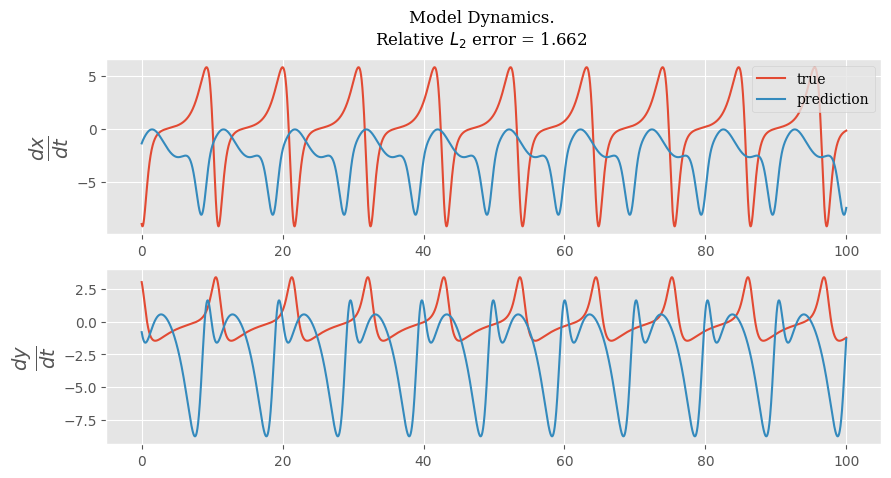

In [61]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,5))
ax1.plot(t_true, xdot_true[:,0], label="true")
ax1.plot(t_true, xdot_pred_ps[:,0], label = "prediction")
ax1.set_ylabel(r"$\frac{dx}{dt}$", size=20)
ax1.legend(prop={'family': 'serif'},)
ax2.plot(t_true, xdot_true[:,1])
ax2.plot(t_true, xdot_pred_ps[:,1])
ax2.set_ylabel(r"$\frac{dy}{dt}$",size=20)
plt.suptitle("Model Dynamics.\n"+f"Relative $L_2$ error = {l2_err_ps:.3f}", family='serif')
plt.show()